In [58]:
import numpy as np
import pandas as pd
from PIL import Image 

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

LEARNING_RATE = 1e-4

TRAINING_ITERATIONS = 100000

DROPOUT = 0.5
BATCH_SIZE = 50


VALIDATION_SIZE =0
IMAGE_TO_DISPLAY = 10

IS_TRAIN = 0

In [3]:
data = pd.read_csv('mnist_train.csv')

#print('data({0[0]},{0[1]})'.format(data.shape))
#print(data.head(3))


In [4]:
images = data.iloc[:,1:].values
images = images.astype(np.float)
images = np.multiply(images ,1.0/255.0)
print('images({0[0]},{0[1]})'.format(images.shape))

images(59999,784)


In [5]:
image_size = images.shape[1]
print(' image_size  => {0}'.format(image_size))

image_width = image_height = np.ceil(np.sqrt(image_size).astype(np.uint8))

print('image_width = >{0}\n image_height =>{1}'.format(image_width,image_height))

 image_size  => 784
image_width = >28.0
 image_height =>28.0


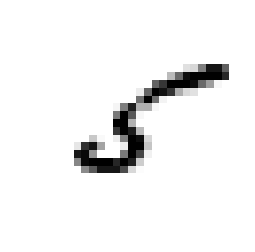

In [6]:
def display(img):
    one_image = img.reshape(28,28)
    plt.axis('off')
    plt.imshow(one_image,cmap =cm.binary)

display(images[IMAGE_TO_DISPLAY])

In [7]:
labels_flat = data.iloc[:,0].values.ravel()
print('labels_flat({0})'.format(len(labels_flat)))
print('labels_flat[{0}] =>{1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))


labels_flat(59999)
labels_flat[10] =>5


In [8]:
labels_count = np.unique(labels_flat).shape[0]
print(labels_count)

10


In [9]:
def dense_to_one_hot(labels_dense,num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels,num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] =1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat,labels_count)
labels = labels.astype(np.uint8)

print(labels.shape)
print('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))



(59999, 10)
labels[10] => [0 0 0 0 0 1 0 0 0 0]


In [10]:
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print(train_images.shape)
print(validation_images.shape)



(59999, 784)
(0, 784)


In [11]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev = 0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1 ,shape = shape)
    return tf.Variable(initial)

In [12]:
def conv2d(x,W):
    
    return tf.nn.conv2d(x,W,strides = [1,1,1,1],padding = 'SAME')

In [13]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'SAME')

In [14]:
x = tf.placeholder(tf.float32,shape = [None,image_size])
y_ = tf.placeholder(tf.float32,shape = [None , labels_count])

In [15]:
#first conv  layer
W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

image = tf.reshape(x,[-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(image,W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [16]:
#second conv layer
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [17]:
W_fc1 = weight_variable([7*7*64,1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1) + b_fc1)


In [18]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)


In [19]:
W_fc2 = weight_variable([1024,labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2) + b_fc2)

In [20]:
cross_entropy =  -tf.reduce_sum(y_ * tf.log(y))
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))  #argmax（y，1-） 返回列中最大值所在的位置

accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))   #求平均值

In [21]:
predict = tf.argmax(y,1)

In [22]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

def next_batch(batch_size):
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > num_examples:
        epochs_completed += 1
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        
        start = 0
        index_in_epoch = batch_size
        assert batch_size <=num_examples
    end = index_in_epoch
    
    return train_images[start:end] , train_labels[start:end]


INFO:tensorflow:Restoring parameters from ckpt/mnist.ckpt
[3]


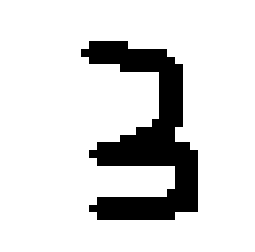

In [59]:
saver = tf.train.Saver() 
checkpoint_dir = ''
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_accuracies = []
    validation_accuracies = []
    x_range = []
    display_step = 1
    
    if IS_TRAIN:
        for i in range(TRAINING_ITERATIONS):
            batch_xs , batch_ys  = next_batch(BATCH_SIZE)
            if i%display_step ==0 or (i+1) == TRAINING_ITERATIONS:
                train_accuracy = accuracy.eval(feed_dict = {x:batch_xs,y_:batch_ys,keep_prob:1.0})
                if(VALIDATION_SIZE):
                    validation_accuracy = accuracy.eval(feed_dict = {x: validation_images[:VALIDATION_SIZE],
                                                                     y_:validation_labels[:VALIDATION_SIZE],
                                                                     keep_prob:1.0})
                    print('training_accuracy/validation_accuracy => %.2f/%.2f for step %d'%(train_accuracy,validation_accuracy,i))
                    validation_accuracies.append(validation_accuracy)
                else:
                    print(' training_accuracy => %4f for step %d'%(train_accuracy ,i))
                train_accuracies.append(train_accuracy)
                print(' mean_training_accuracy => %4f '%(tf.reduce_mean(tf.cast(train_accuracies,tf.float32)).eval()))
                x_range.append(i)
                if i%(display_step *10) == 0 and i:
                    display_step *= 10
            sess.run(train_step,feed_dict={x:batch_xs,y_:batch_ys,keep_prob:DROPOUT})
        saver.save(sess,'ckpt/mnist.ckpt')
        
        plt.plot(x_range,train_accuracies,'-b',label = 'Training')
        plt.legend(loc = 'lower right',frameon = False)
        plt.ylim(ymax = 1.1,ymin = 0.8)
        plt.ylabel('accuracy')
        plt.xlabel('step')
        plt.show()
    else:
        
        model_file=tf.train.latest_checkpoint('ckpt/')
        saver.restore(sess,model_file)
        mnist_img = Image.open("3.bmp")
        input = (1- np.asarray(mnist_img,dtype=np.uint8)).reshape(1,784)
        result = predict.eval(feed_dict = {x: input,keep_prob:1.0})
        print(result)
        display(input)
